In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.spatial import ConvexHull
import time
n=10
p=np.random.rand(n)**0.5*1j**(4*np.random.rand(n)) 
#p=1j**(4*np.random.rand(n)) #all points on perimeter 

In [2]:
def hullVertices(p,tol=None):
    if tol==None:tol=0 # do not consider points closer than "tol" to the existing hull as new hull point
    def hv(vl,vr,vs):
        dv=p[vr]-p[vl]
        if (len(vs)==0) or (dv==0): 
            return
        rotps=(p[vs]-p[vl])*(abs(dv)/dv)
        vmin=np.argmin(rotps.imag)
        vsmin=vs[vmin]
        if vl==vsmin or vr==vsmin:
            return
        if rotps[vmin].imag>= -tol:#concave point 
            return
        rotps_imag_negative=(rotps.imag< -tol)#only consider points to the right of vl -> vr 
        yield from hv(vl,vsmin,vs[(rotps.real<rotps[vmin].real)&rotps_imag_negative])
        yield vsmin
        yield from hv(vsmin,vr,vs[(rotps.real>rotps[vmin].real)&rotps_imag_negative]) 
    vmin=np.argmin(p.real)
    vmax=np.argmax(p.real)
    if p[vmin].real == p[vmax].real:#real parts are all the same. 
      vmin=np.argmin(p.imag)
      vmax=np.argmax(p.imag)
    allvs=np.arange(len(p),dtype=int)
    yield vmax
    yield from hv(vmax,vmin,allvs)
    yield vmin
    yield from hv(vmin,vmax,allvs) 


In [3]:
def hull2Segments(p):
  p1=np.roll(p,-1)
  dp=p1-p
  l=abs(dp)
  udp=dp/l#unit vector
  a=np.log(np.roll(udp,-1)/udp).imag
  for l,a in zip(l,a):
      yield (l,0)
      yield (0,a)

In [4]:
from cmath import exp
def Segments2Complex(Segs,p0=0+0j,scale=1.0,a0=1+0j,tol=0.05,offs=0,loops=1,return_heading=False):
  """
  The parameter "tol defines the resolution. It is the maximum allowable
  difference between circular arc segment, and the secant between the
  calculated points on the arc. Smaller values for tol will result in
  more points per segment.
  """
  a=a0/abs(a0)
  p=p0
  p-=1j*a*offs
  for _ in range(loops):
      for l,da in Segs:
        l=l*scale
        if da!=0:
          r=l/da
          r+=offs
          if r!=0:
            l=r*da
            dl=2*abs(2*r*tol)**0.5
            n=max(int(abs(6*(da/(2*pi)))),int(l//dl)+1)
          else:
            n=1
          dda=exp(1j*da/n)
          dda2=dda**0.5
          v=(2*r*dda2.imag)*dda2*a
        else:
          n=1
          dda=1
          v=l*a
        for _ in range(n):
          p+=v
          if return_heading:
            yield p,a
          else:
            yield p
          v*=dda
          a*=dda


ConvexHull time: 0.002796707907691598
time for hullVertices: 0.00014841696247458458
[4 2 5 7]
[2 5 7 4]


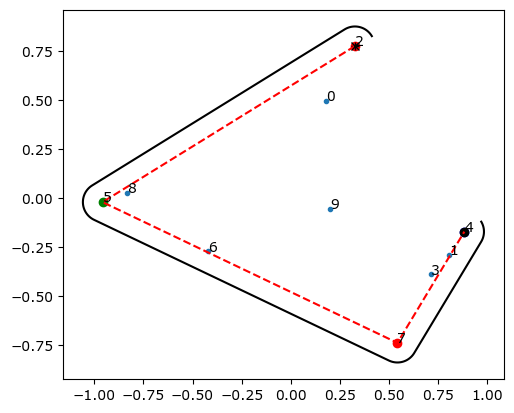

In [5]:

plt.plot(p.real,p.imag,'.')
pmin=p[np.argmin(p.imag)]
pmax=p[np.argmax(p.imag)]
plt.plot([pmin.real,pmax.real],[pmin.imag,pmax.imag],'ro')
def fpmax(p1,p2,p):
  prot=(p1-p2)**-1*p
  return p[np.argmax(prot.imag)]
pmaxr=fpmax(pmin,pmax,p)
pmaxl=fpmax(pmax,pmin,p)
plt.plot(pmaxr.real,pmaxr.imag,'bo')
plt.plot(pmaxl.real,pmaxl.imag,'go')
pmaxrr=fpmax(pmin,pmaxr,p)
pmaxrl=fpmax(pmaxr,pmax,p)
plt.plot(pmaxrr.real,pmaxrr.imag,'ko')
plt.plot(pmaxrl.real,pmaxrl.imag,'k+')
t0=time.perf_counter()
hull=ConvexHull(np.vstack((p.real,p.imag)).T) 
chv=hull.vertices
print('ConvexHull time:',time.perf_counter()-t0)
plt.plot(p.real[hull.vertices],p.imag[hull.vertices],'r--')
plt.plot(p.real[hull.vertices[0]],p.imag[hull.vertices[0]],'kx',zorder=5  ) 
t0=time.perf_counter()
hv=list(hullVertices(p))
print('time for hullVertices:',time.perf_counter()-t0) 
print(np.array(hv))
print(hull.vertices)
for i, pi in enumerate(p):
    plt.annotate(f'{i}', (pi.real, pi.imag))
    pass
hs=list(hull2Segments(p[hv]))
p0,p1=p[hv[:2]]
phs=np.array(list(Segments2Complex(hs,p0=p0,a0=p1-p0,offs=0.1,tol=0.001)))
plt.gca().set_aspect('equal')
plt.plot(phs.real,phs.imag,'k-');